<a href="https://colab.research.google.com/github/abj360/solace-app/blob/main/Solace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note: Change Hardware Accelerator to GPU to train faster (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)**

# Solace - Machine Learning App for Malaria Diagnosis

In [ ]:
#@title Run this to prepare our libraries and data!

!pip -q install pyngrok > /dev/null
!pip -q install streamlit > /dev/null
!pip -q install patool > /dev/null
!pip -q install keras==3.5.0 > /dev/null


import cv2
import gdown
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import patoolib
import streamlit as st

from joblib import dump
from tqdm import tqdm
from pyngrok import ngrok

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import SGD


# Downloading data
DATA_ROOT = '/content'
os.makedirs(DATA_ROOT, exist_ok=True)

!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/malaria_images.zip" > /dev/null
!unzip "malaria_images.zip" > /dev/null

uninfected_img_paths = glob.glob('/content/malaria_images/Uninfected/*png')
parasitized_img_paths = glob.glob('/content/malaria_images/Parasitized/*png')

samples_per_class = 3000
total_samples = 2 * samples_per_class

# Make X and y from data
X = []
y = []

for i in tqdm(range(samples_per_class)):
  img = cv2.imread(uninfected_img_paths[i])
  X.append(cv2.resize(img, (50,50))) # standardize image size
  y.append(0)

for i in tqdm(range(samples_per_class)):
  img = cv2.imread(parasitized_img_paths[i])
  X.append(cv2.resize(img, (50,50))) # standardize image size
  y.append(1)

X = np.array(X)
y = np.array(y)

print("Created our X and y variables")


# Save some sample images for trying out Streamlit app
blood_samples_dir = 'blood_samples'
if (os.path.exists(blood_samples_dir) == False):
  os.mkdir(blood_samples_dir)

for i, img in enumerate(X[samples_per_class-5:samples_per_class]):
  plt.imsave(f'uninfected_test_img_{i}.jpg', img)

for i, img in enumerate(X[samples_per_class:samples_per_class+5]):
  plt.imsave(f'parasitized_test_img_{i}.jpg', img)




--2025-02-12 13:11:31--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/malaria_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.207, 209.85.145.207, 142.250.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353755287 (337M) [application/zip]
Saving to: ‘malaria_images.zip.1’

malaria_images.zip. 100%[===================>] 337.37M   201MB/s    in 1.7s    

2025-02-12 13:11:33 (201 MB/s) - ‘malaria_images.zip.1’ saved [353755287/353755287]

replace malaria_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace malaria_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


100%|██████████| 3000/3000 [00:02<00:00, 1292.52it/s]

Created our X and y variables


In this notebook, we'll build a machine learning model to diagnose malaria and deploy our model to a mobile-friendly web app.

**Discuss: Why is it important to deploy AI models to apps, especially in healthcare? Who could benefit?**

One huge benefit is that machine learning apps can quickly and cheaply screen people for diseases! Check out a few examples:
*  [Detecting early Parkinson's disease](https://parkinsonsnewstoday.com/2019/01/15/smartphone-app-identifies-early-symptoms-motor-disorders-study/) by analyzing finger-tapping
*  [Recognizing asymptomatic COVID-19](https://news.mit.edu/2020/covid-19-cough-cellphone-detection-1029) based on particular cough sounds
*  (Developed by a high-schooler!) [Screening for eye disease with computer vision](https://www.youtube.com/watch?v=kLx4ey4d8DQ) in parts of the world where there aren't enough doctors

Because billions of people worldwide have smartphones, ML apps have the potential to get huge numbers of people diagnosed and treated!

Today, we'll build an app to help fight one of the world's most terrible diseases: malaria, which every year infects over 200 million people and kills more than 200,000 children. Our goal is to help healthcare workers in rural or developing areas diagnose malaria without expensive lab equipment. Our app will let a healthcare worker upload an image of blood cells under a microscope, and then use computer vision to detect the malaria parasite.

![](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/21/2018/01/parasite.jpg)

We'll split our work into three parts:
*   Back-end: building a machine learning model to classify an image of blood cells
*   Front end: making an easy-to-use, mobile-friendly website that lets users upload an image and outputs the answer
*   Connecting the front-end and back-end so the model can analyze the user's image

# Part 1: Malaria Diagnosis

Let's construct a machine learning model to diagnose malaria!

##Exploring Our Data

Our images of blood cells are stored in `X`, and our corresponding labels (1 = Malaria, 0 = No Malaria) are stored in `y`.



X shape: (6000, 50, 50, 3)
y shape: (6000,)
Diagnosis: 0


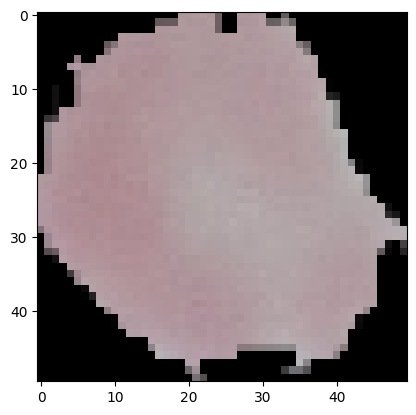

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)
plt.imshow(X[0])
print("Diagnosis:", y[0])

### PCA Visualization

Let's try to visualize our entire dataset. It's tricky with high-dimensional data, but we can use the Principal Component Analysis (PCA) technique to reduce the number of dimensions and visualize it in 2D.


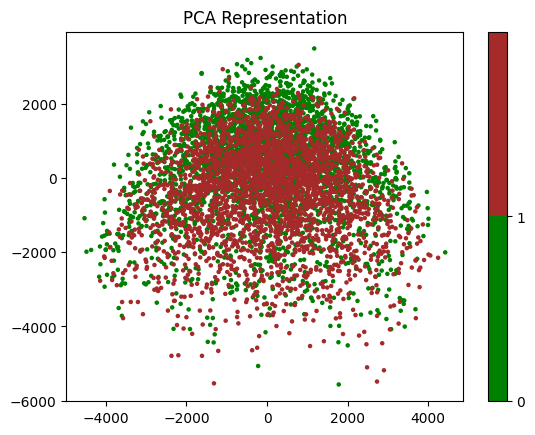

In [ ]:
#@title Run this to perform and visualize PCA! { display-mode: "form" }
pca = PCA(n_components=20)

X_pca = pca.fit_transform(np.reshape(X, (X.shape[0], 7500)))

colors = ["green","brown"]
classes = [0,1]

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors), s=5)
cb = plt.colorbar()
loc = np.arange(0,max(y),max(y)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(classes)
plt.title("PCA Representation")
plt.show()

##Processing Our Data

###Train-Test Split


Now that our data is ready, we can perform our usual `train_test_split`. Pass in our flattened data and our output, `y`. You can use a test size of 0.33.

In [ ]:
X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X, y, test_size=0.33, random_state=42)

##Training Our Model

The model we will try out twe are going to use an expert model called **VGG16** that has been trained to categorize millions of images into tens of thousands of categories. This technique is called **transfer learning**: basically training this model on our data so that it can transfer its expertise to our specific problem.


In [7]:
# load the expert VGG16 network but do not include the final layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (50, 50, 3))

# we add the first 12 layers of VGG16 to our own model vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

# and then add our own layers on top of it
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(1, activation = 'sigmoid'))

vgg_model.compile(loss = 'binary_crossentropy',
          optimizer = SGD(learning_rate=1e-4, momentum=0.95),
          metrics=['accuracy'])

vgg_model.fit(X_train_vgg, y_train_vgg,
              batch_size=64,
              epochs=5,
              verbose=1,
              validation_data=(X_test_vgg, y_test_vgg),
              shuffle=True)

print("Accuracy: {}".format(vgg_model.evaluate(X_test_vgg, y_test_vgg)[1], verbose=0))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 548s 9s/step - accuracy: 0.7208 - loss: 0.8708 - val_accuracy: 0.9359 - val_loss: 0.1886
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 544s 9s/step - accuracy: 0.9376 - loss: 0.1837 - val_accuracy: 0.9505 - val_loss: 0.1488
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 556s 9s/step - accuracy: 0.9529 - loss: 0.1501 - val_accuracy: 0.9475 - val_loss: 0.1685
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 537s 9s/step - accuracy: 0.9602 - loss: 0.1350 - val_accuracy: 0.9500 - val_loss: 0.1387
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 561s 8s/step - accuracy: 0.9628 - loss: 0.1243 - val_accuracy: 0.9561 - val_loss: 0.1465
62/62 ━━━━━━━━━━━━━━━━━━━━ 55s 892ms/step - accuracy: 0.9555 - loss: 0.1392
Accuracy: 0.9560605883598328


##Saving our VGG Model

Now let's save and download our `vgg_model`

In [8]:
from google.colab import files

vgg_model.save("solace_model.keras")

files.download("solace_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Part 2: Setting Up Our Healthcare App

### Setting up Ngrok auth token

In [9]:
!ngrok authtoken 2stAYuQD6aIsjzhXhLPLZR7KiMI_5j5bT8XEFmzBwWtLFV72L

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


### Connecting Our App and Model


Let's connect our app to our model, so that the user can upload an image of a blood slide, the model will analyze the image, and finally the app will display the diagnosis result with some text.

We'll start off by writing our image processing code here in Colab. Although we won't execute it here, it'll be easier to visualize the steps.

In [17]:
# Helpful function for launching our Streamlit app
def launch_website():
  print ("Click this link to try your web app:")
  if (ngrok.get_tunnels() != None):
    ngrok.kill()
  tunnel = ngrok.connect()
  print(tunnel.public_url)
  !streamlit run --server.port 80 app.py > /dev/null
launch_website()

Click this link to try your web app:
https://9fae-34-31-242-42.ngrok-free.app
2025-02-12 14:19:36.553269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739369976.587088   17612 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739369976.596464   17612 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 14:19:41.137059: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


###Designing the interface

In [16]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
import pandas as pd

# Load the trained model
model = tf.keras.models.load_model("solace_model.keras")

# Define class labels
labels = ["No Malaria", "Malaria Detected"]

def predict(image):
    """Preprocesses the image and makes a prediction."""
    small = cv2.resize(image, (50, 50))
    small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
    small = np.array([small]) / 255.0  # Normalize

    prob = model.predict(small)[0, 0]
    prediction = int(prob > 0.5)
    confidence = prob * 100 if prediction == 1 else (1 - prob) * 100  # Convert to percentage

    return labels[prediction], confidence

# Streamlit UI
st.set_page_config(page_title="Solace - Blood Slide Diagnosis", layout="centered")
st.title("🩸 Solace: AI-Powered Malaria Diagnosis")
st.write("Upload a blood slide image to detect malaria.")

# Upload file
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Read and display image
    image = Image.open(uploaded_file)
    image_np = np.array(image)
    st.image(image, caption="Uploaded Image", use_container_width=True)

    # Predict
    with st.spinner("Analyzing image..."):
        class_name, confidence = predict(image_np)

    # Display results
    st.success(f"**Prediction:** {class_name}")
    st.info(f"**Confidence:** {confidence:.2f}%")

    # Provide additional guidance
    if class_name == "Malaria Detected":
        st.error("⚠️ Malaria detected. Please consult a medical professional immediately.")
    else:
        st.success("✅ No malaria detected. However, always consult a doctor for confirmation.")

st.markdown("---")
st.caption("*Disclaimer: This tool is for informational purposes only and not a substitute for professional medical advice.*")

Overwriting app.py
